In [4]:
#lib import
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn'

In [5]:
#import dataset
telecom_df = pd.read_csv("telecom_churn_data.csv")
telecom_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [6]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [7]:
telecom_df.shape

(99999, 226)

In [8]:
# Filter High value Customers
# High-value customers : Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of average recharge amount in the first two months.

# lets find out total amount spent by customers on data recharge,we have two colums available to find this out 
# First column is av_rech_amt_data_x (x represents month here, would be either 6 or 7 or 8)
# Second column is total_rech_data_x (x represnts month here, would be either 6 or 7 or 8)
# Lets introduce a new column total_rech_data_amt_x which can be calculated as av_rech_amt_data_x * total_rech_data_x

In [9]:
telecom_df['total_rech_data_amt_6'] = telecom_df['av_rech_amt_data_6'] * telecom_df['total_rech_data_6']
telecom_df['total_rech_data_amt_7'] = telecom_df['av_rech_amt_data_7'] * telecom_df['total_rech_data_7']
telecom_df['total_rech_data_amt_8'] = telecom_df['av_rech_amt_data_8'] * telecom_df['total_rech_data_8']
telecom_df['total_rech_data_amt_9'] = telecom_df['av_rech_amt_data_9'] * telecom_df['total_rech_data_9']

# We dont require columns av_rech_amt_data_x,total_rech_data_x (x = 6/7/8) so drop them:

telecom_df.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',
'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis = 1,inplace = True)


In [10]:
# Find the average recharge done in the first two months(June & July), the good phase
# total amount spend would be the sum of total data recharge done & total call/sms recharges
telecom_av_rech = (telecom_df['total_rech_amt_6'].fillna(0) 
+ telecom_df['total_rech_amt_7'].fillna(0) 
+ telecom_df['total_rech_data_amt_6'].fillna(0) 
+ telecom_df['total_rech_data_amt_7'].fillna(0))/2

In [11]:
# 70 percentile of  calculated average amount
percentile_70 = np.percentile(telecom_av_rech, 70.0)
print("70 percentile : ", percentile_70)

# Fitler the data based on 70th percentile
telecom_hv_cust = telecom_df[telecom_av_rech >= percentile_70]

print("Dimensions of filtered dataset:",telecom_hv_cust.shape)

70 percentile :  478.0
Dimensions of filtered dataset: (30001, 222)


In [12]:
#Adding a new column "churn" with values 1 (churn) or 0 (non-churn) and calculate churn/non-churn:

telecom_hv_cust['churn'] = np.where(telecom_hv_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)
telecom_hv_cust.head(10)

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/3257983365.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust['churn'] = np.where(telecom_hv_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)


,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_data_amt_6,total_rech_data_amt_7,total_rech_data_amt_8,total_rech_data_amt_9,churn
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,NaN,1
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1069.180,...,802,57.74,19.38,18.74,0.00,NaN,NaN,NaN,NaN,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,378.721,...,315,21.03,910.65,122.16,0.00,NaN,354.0,207.0,NaN,0
21,7002124215,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,514.453,...,720,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
23,7000887461,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,74.350,...,604,40.45,51.86,0.00,0.00,NaN,712.0,540.0,252.0,0
33,7000149764,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,977.020,...,1328,358.10,2706.83,1714.67,0.00,5285.0,20424.0,455.0,1814.0,0
38,7000815202,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,363.987,...,1155,0.00,0.00,0.00,0.00,NaN,NaN,NaN,207.0,0
41,7000721289,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,482.832,...,2010,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
48,7000294396,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,1873.271,...,1265,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0
53,7002188521,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,978.077,...,697,0.00,0.00,0.00,0.00,344.0,575.0,23.0,92.0,0


In [13]:
#finding churn/non churn percentage
telecom_hv_cust['churn'].value_counts()/len(telecom_hv_cust)*100

0    91.863605
1     8.136395
Name: churn, dtype: float64

In [14]:
#91.8 % of the customers do not churn, it might be class imbalance, we will treat that later in solution.

In [15]:
#check columns with no variance in their values and drop such columns
for i in telecom_hv_cust.columns:
    if telecom_hv_cust[i].nunique() == 1:
        print("\nColumn",i,"no variance and contains only", telecom_hv_cust[i].nunique(),"unique value")
        print("Drop column",i)
        telecom_hv_cust.drop(i,axis=1,inplace = True)

print("\nDimensions of updated dataset:",telecom_hv_cust.shape)


Column circle_id no variance and contains only 1 unique value
Drop column circle_id

Column loc_og_t2o_mou no variance and contains only 1 unique value
Drop column loc_og_t2o_mou

Column std_og_t2o_mou no variance and contains only 1 unique value
Drop column std_og_t2o_mou

Column loc_ic_t2o_mou no variance and contains only 1 unique value
Drop column loc_ic_t2o_mou

Column last_date_of_month_6 no variance and contains only 1 unique value
Drop column last_date_of_month_6

Column last_date_of_month_7 no variance and contains only 1 unique value
Drop column last_date_of_month_7

Column last_date_of_month_8 no variance and contains only 1 unique value
Drop column last_date_of_month_8

Column last_date_of_month_9 no variance and contains only 1 unique value
Drop column last_date_of_month_9

Column std_og_t2c_mou_6 no variance and contains only 1 unique value
Drop column std_og_t2c_mou_6

Column std_og_t2c_mou_7 no variance and contains only 1 unique value
Drop column std_og_t2c_mou_7

Col

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2142913294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust.drop(i,axis=1,inplace = True)
/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2142913294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust.drop(i,axis=1,inplace = True)
/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2142913294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h


Column std_ic_t2o_mou_6 no variance and contains only 1 unique value
Drop column std_ic_t2o_mou_6

Column std_ic_t2o_mou_7 no variance and contains only 1 unique value
Drop column std_ic_t2o_mou_7

Column std_ic_t2o_mou_8 no variance and contains only 1 unique value
Drop column std_ic_t2o_mou_8

Column std_ic_t2o_mou_9 no variance and contains only 1 unique value
Drop column std_ic_t2o_mou_9

Dimensions of updated dataset: (30001, 207)


/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2142913294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust.drop(i,axis=1,inplace = True)
/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2142913294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust.drop(i,axis=1,inplace = True)
/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2142913294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [16]:
#New dimensions are (30001,207)

In [17]:
#check for null
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

arpu_3g_9                   49.268358
fb_user_9                   49.268358
date_of_last_rech_data_9    49.268358
max_rech_data_9             49.268358
count_rech_2g_9             49.268358
                              ...    
max_rech_amt_8               0.000000
max_rech_amt_7               0.000000
max_rech_amt_6               0.000000
total_rech_amt_9             0.000000
churn                        0.000000
Length: 207, dtype: float64

In [18]:
# Drop Columns with > 40% of missing values except 9th Month's columns
cols = telecom_hv_cust.columns
telecom_null = telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)
telecom_null_df = pd.DataFrame({'col_name': cols,'perc_null': telecom_null})

drop_cols = telecom_null_df.loc[(telecom_null_df["col_name"].str.contains('_9')==False) & (telecom_null_df["perc_null"] > 40.0)]["col_name"]
print("list of columns dropped:",drop_cols)

list of columns dropped: date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6     

In [19]:
# lets drop these columns
telecom_hv_cust.drop(drop_cols, axis=1,inplace = True)

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2688356334.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust.drop(drop_cols, axis=1,inplace = True)


In [20]:
telecom_hv_cust.shape

(30001, 180)

In [21]:
#Cols dropped to 180 from 207
#Columns that can be changed to integers, floats or date types
object_col = telecom_hv_cust.select_dtypes(include=['object'])
print(object_col.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [22]:
#Convert to datetime
for col in object_col.columns:
    telecom_hv_cust[col] = pd.to_datetime(telecom_hv_cust[col])

telecom_hv_cust.shape

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2621592254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust[col] = pd.to_datetime(telecom_hv_cust[col])
/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2621592254.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust[col] = pd.to_datetime(telecom_hv_cust[col])
/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2621592254.py:3: SettingWithCopyWarning: 
A value is trying to be set o

(30001, 180)

In [23]:
#Checking correlation to drop the highly correlated features:
corr = telecom_hv_cust.corr()
corr.loc[:,:] = np.tril(corr, k=-1)
corr = corr.stack()
corr[(corr > 0.60) | (corr < -0.60)].sort_values()

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/3842190900.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = telecom_hv_cust.corr()


monthly_3g_6      vol_3g_mb_6         0.601308
total_ic_mou_7    loc_ic_t2t_mou_7    0.601684
arpu_2g_9         count_rech_3g_9     0.602386
total_og_mou_8    onnet_mou_9         0.603450
total_rech_amt_8  arpu_6              0.603673
                                        ...   
isd_og_mou_8      isd_og_mou_7        0.949809
                  isd_og_mou_6        0.950194
total_rech_amt_9  arpu_9              0.950539
total_rech_amt_8  arpu_8              0.955351
sachet_2g_9       count_rech_2g_9     0.980131
Length: 337, dtype: float64

In [24]:
# we will drop the columns with high correlation (+/- 60%)
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']

In [25]:
telecom_hv_cust.drop(drop_col_list, axis=1, inplace=True)
telecom_hv_cust.shape

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2778228625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust.drop(drop_col_list, axis=1, inplace=True)


(30001, 125)

In [26]:
#Deleting 9th month columns because churn/non-churn will be predicted later based on data from the 1st 3 months
cols_to_drop = [col for col in telecom_hv_cust.columns if '_9' in col]
print(cols_to_drop)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'total_rech_data_amt_9']


In [27]:
telecom_hv_cust.drop(cols_to_drop, axis=1, inplace=True)
telecom_hv_cust.shape

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/314195583.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telecom_hv_cust.drop(cols_to_drop, axis=1, inplace=True)


(30001, 88)

In [28]:
#check for null again
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)

loc_og_t2c_mou_8      3.913203
roam_ic_mou_8         3.913203
spl_og_mou_8          3.913203
isd_og_mou_8          3.913203
std_og_mou_8          3.913203
                        ...   
last_day_rch_amt_7    0.000000
last_day_rch_amt_8    0.000000
vol_2g_mb_6           0.000000
vol_2g_mb_7           0.000000
churn                 0.000000
Length: 88, dtype: float64

In [29]:
# Drop rows with null values
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['onnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['offnet_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['roam_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_t2c_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_og_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['og_others_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['loc_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2t_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_t2f_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['std_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['spl_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['isd_ic_mou_8'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_6'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_7'])]
telecom_hv_cust = telecom_hv_cust[~np.isnan(telecom_hv_cust['ic_others_8'])]

In [30]:
(telecom_hv_cust.isnull().sum() * 100 / len(telecom_hv_cust)).sort_values(ascending = False)
#All null values handled

mobile_number         0.0
arpu_6                0.0
last_day_rch_amt_6    0.0
max_rech_amt_8        0.0
max_rech_amt_7        0.0
                     ... 
std_og_mou_8          0.0
std_og_mou_7          0.0
std_og_mou_6          0.0
std_og_t2f_mou_8      0.0
churn                 0.0
Length: 88, dtype: float64

In [31]:
# function to plot correlation matrix:

In [32]:
def plotCorrMat(df, graphWidth):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [33]:
# function to plot scatter plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
         ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [34]:
# calling the function to plot the graphs

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/2372613981.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


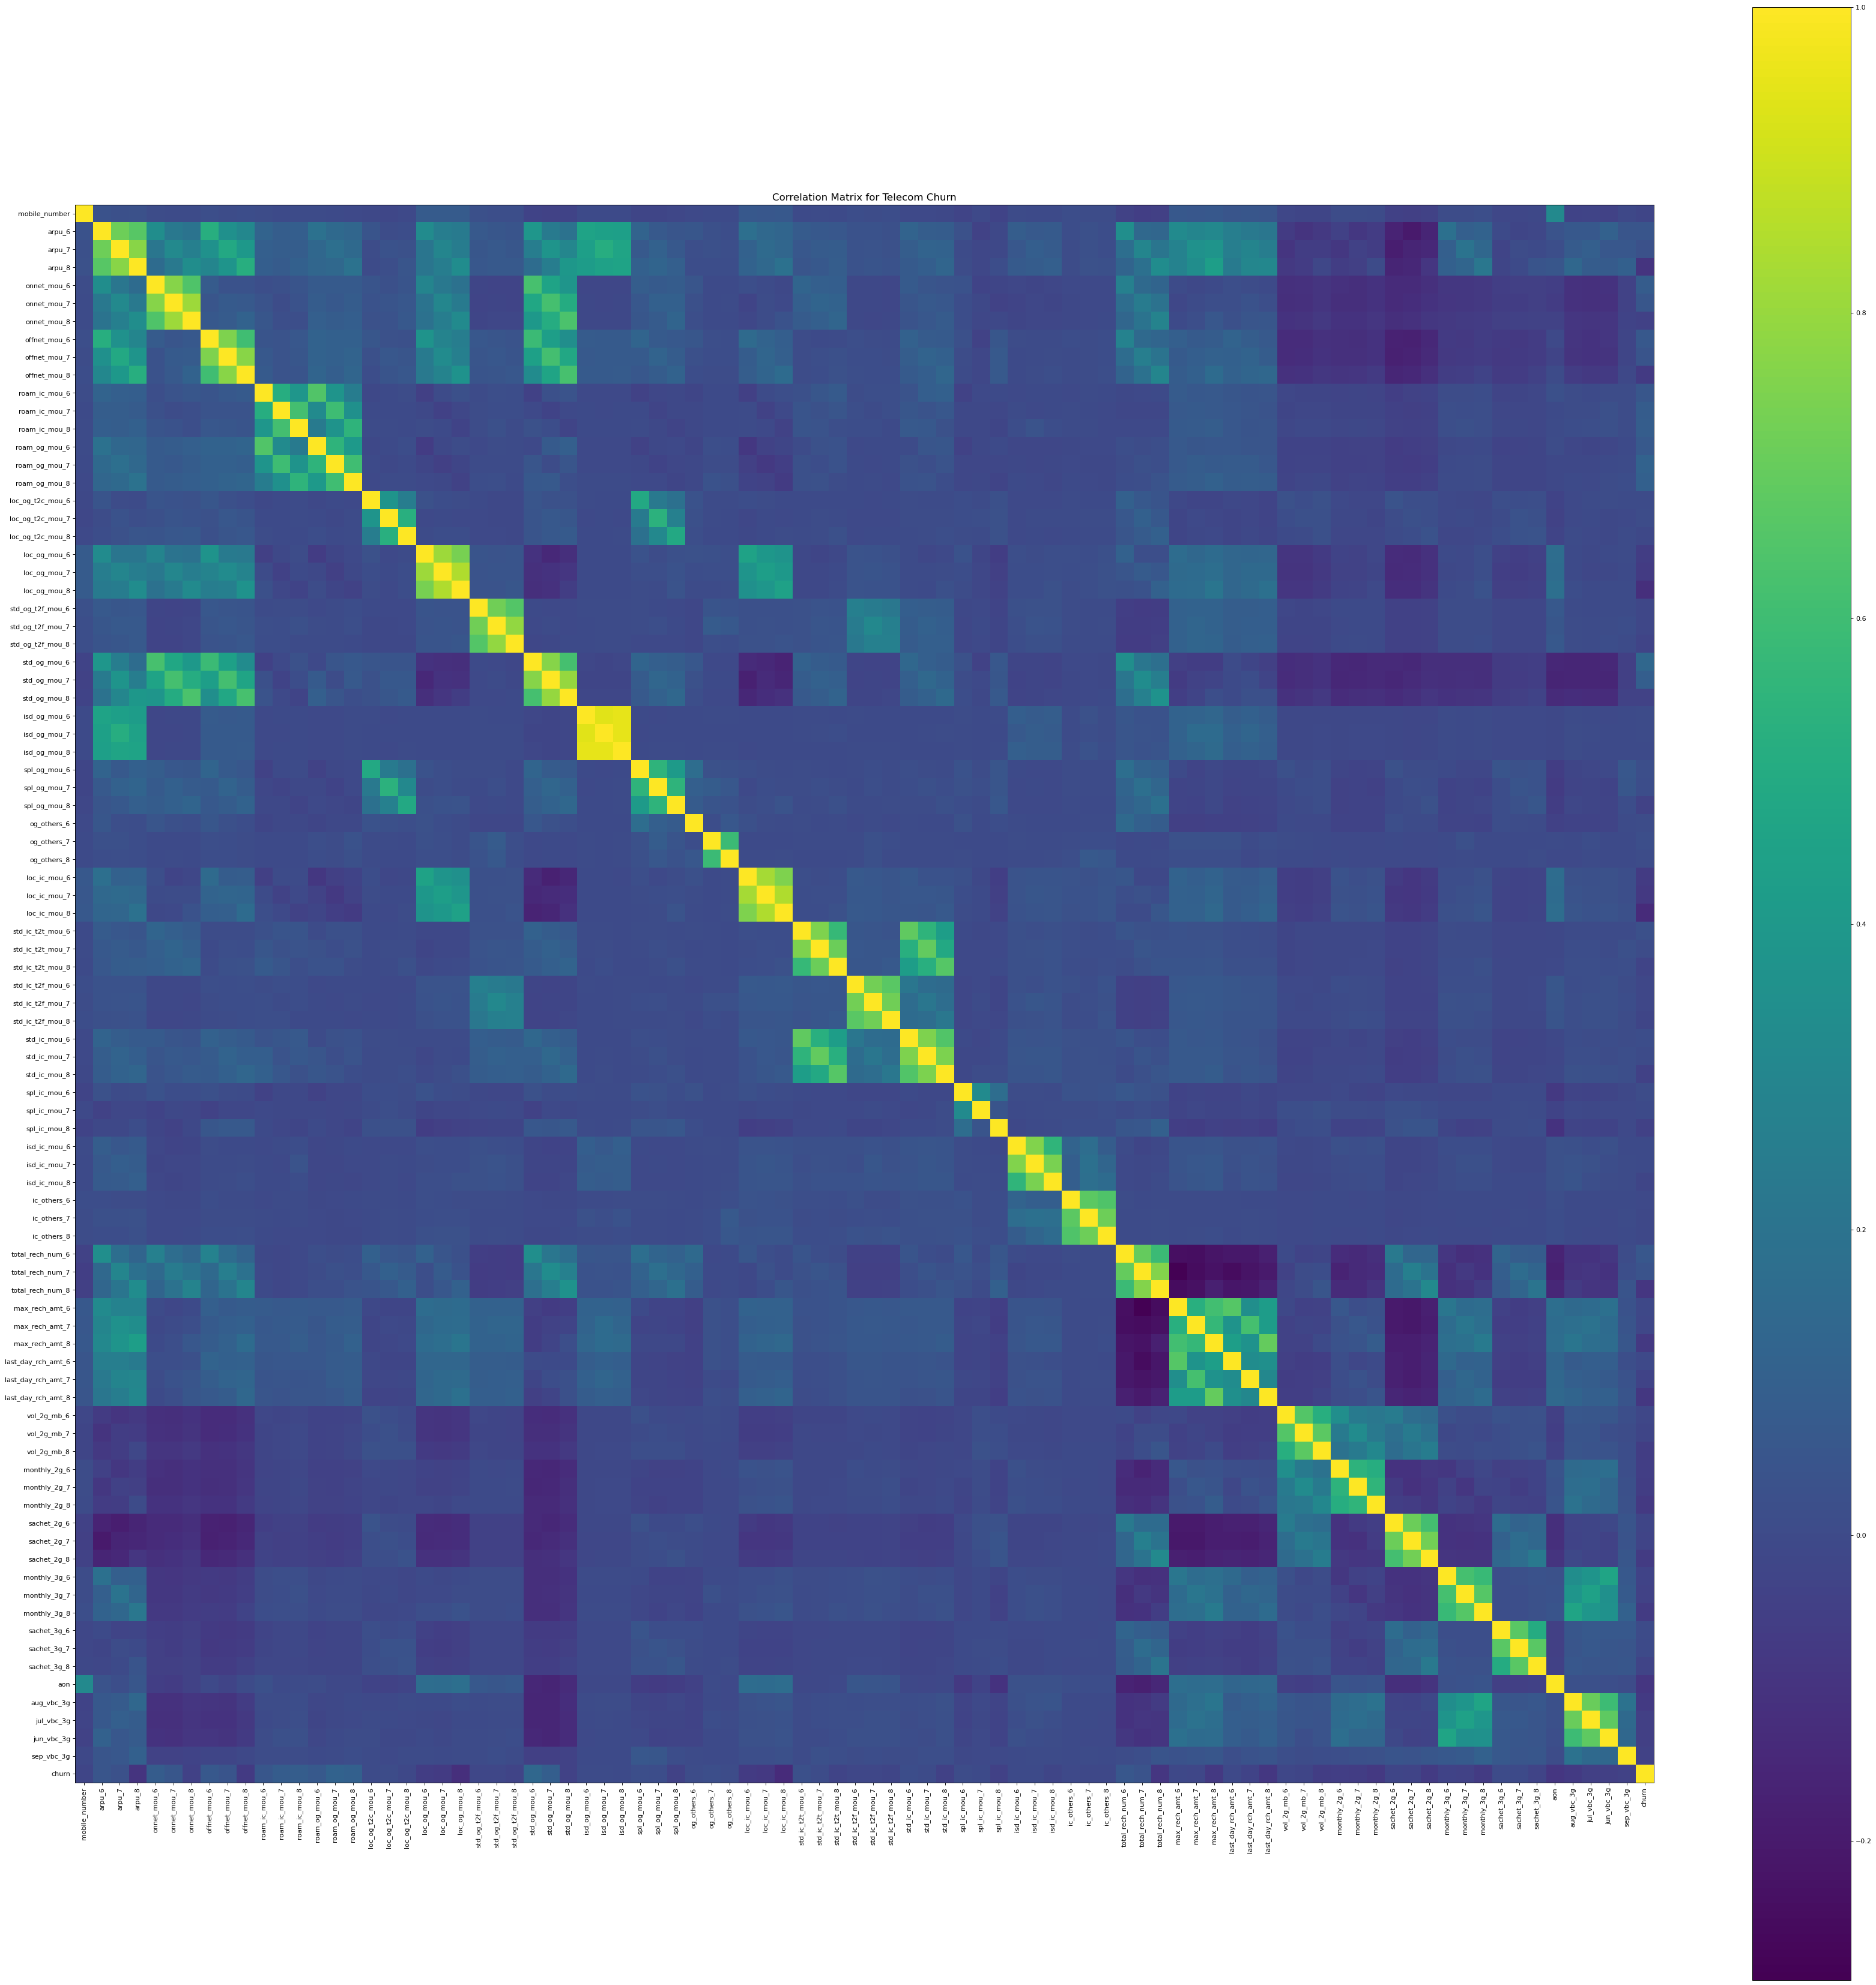

In [35]:
plotCorrMat(telecom_hv_cust, 53)

/var/folders/zl/x29m5tmd6b73c9c4rvdw7fgw0000gn/T/ipykernel_24802/1285009704.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


ModuleNotFoundError: No module named 'scipy'

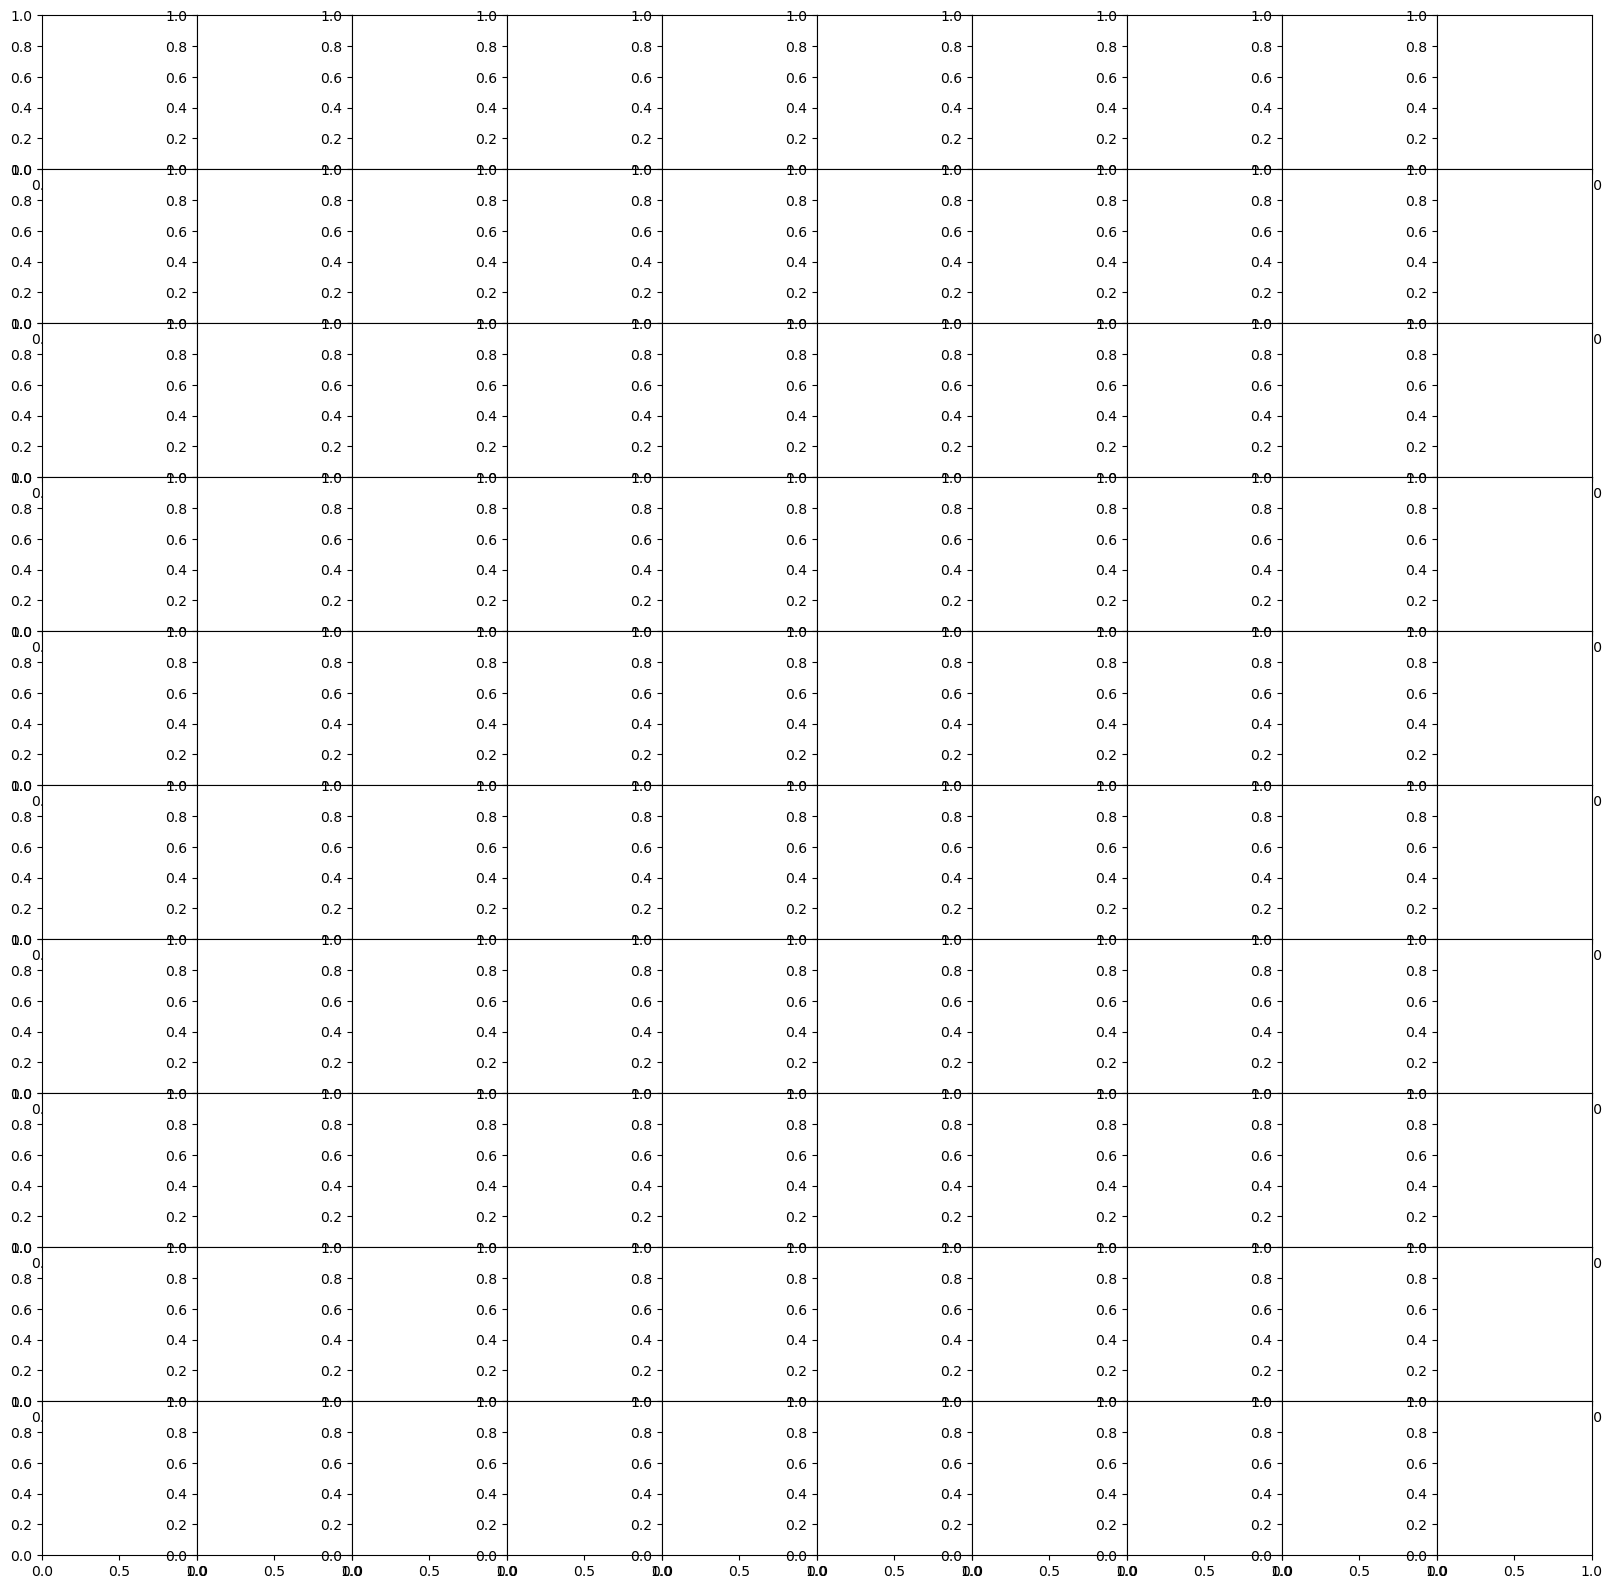

In [36]:
plotScatterMatrix(telecom_hv_cust, 20, 10)

In [ ]:
#Derive some new feautres from the existing columns
col_list = telecom_hv_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (telecom_hv_cust.shape)

# lets take the average now
for idx, col in enumerate(col_list.unique()):
    avg_col_name = "avg_"+col+"_av67" # lets create the column name dynamically
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom_hv_cust[avg_col_name] = (telecom_hv_cust[col_6]  + telecom_hv_cust[col_7])/ 2
# created a new colulmn, which would be average  of 6th & 7th months

In [ ]:
#columns to drop
print ("dimension of updated dataset after creating dervied features:",telecom_hv_cust.shape)
col_drop = telecom_hv_cust.filter(regex='_6|_7').columns
telecom_hv_cust.drop(col_drop, axis=1, inplace=True)

print("dimension of dataset after dropping un-necessary columns:",telecom_hv_cust.shape)

In [ ]:
# conevrt AON in months
telecom_hv_cust['aon_mon'] = telecom_hv_cust['aon']/30
telecom_hv_cust.drop('aon', axis=1, inplace=True)
telecom_hv_cust['aon_mon'].head()

In [ ]:
plotCorrMat(telecom_hv_cust, 53)

In [ ]:
plotScatterMatrix(telecom_hv_cust, 20, 10)

In [ ]:
ax = sns.distplot(telecom_hv_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'purple', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 10})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure in months')
ax.set_title('Tenure Graph')
# Graph showing the tenure of the customers

In [ ]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom_hv_cust['tenure_range'] = pd.cut(telecom_hv_cust['aon_mon'], tn_range, labels=tn_label)
telecom_hv_cust['tenure_range'].head(10)

In [ ]:
#Checking correlation of churn with other columns
plt.figure(figsize=(10,5))
telecom_hv_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')


In [ ]:
#  Avg Outgoing Calls & calls on romaning for 6 & 7th months are positively correlated with churn. 
#  Avg Revenue, No. Of Recharge for 8th month has negative correlation with churn.

In [ ]:
telecom_hv_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8', y='arpu_8')
#scatter plot between total recharge and avg revenue for the 8th month

In [ ]:
telecom_hv_cust[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon', y='avg_arpu_av67')

In [ ]:
#Churn Vs other important features
sns.boxplot(x = telecom_hv_cust.churn, y = telecom_hv_cust.aon_mon)

In [ ]:
# Tenured customers do no churn
# churn Vs Base Cost
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 0)],
                color="Blue", shade = True)
ax = sns.kdeplot(telecom_hv_cust.avg_max_rech_amt_av67[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Red", shade= True)
ax.legend(["NoChurn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume cost')
ax.set_title('Churn Vs Base Cost')

In [ ]:
# churn vs max rechare amount
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 0)],
                color="Blue", shade = True)
ax = sns.kdeplot(telecom_hv_cust.max_rech_amt_8[(telecom_hv_cust["churn"] == 1)],
                ax =ax, color="Red", shade= True)
ax.legend(["NoChurn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

In [ ]:
# Creating new dataset for model building
df = telecom_hv_cust[:].copy()

# Drop tenure range because it is highly correlated with AON MONTH column
df.drop('tenure_range', axis=1, inplace=True)
df.drop('mobile_number', axis=1, inplace=True)
df.head(10)

In [ ]:
# Creating X & y dataset for model building, X will not have "churn" and y will only have "churn"
X = df.drop(['churn'], axis=1)
y = df['churn']

df.drop('churn', axis=1, inplace=True)

In [ ]:
#scaling on the dataset

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
# Splitting dateset into train and test"


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)
print("Dimension of X_train:", X_train.shape)
print("Dimension of X_test:", X_test.shape)

In [ ]:
#Lets balance the dataset
!pip install imbalanced-learn==0.6.0
!pip install scikit-learn==0.22.1

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=0)
X_tr,y_tr = sm.fit_sample(X_train,y_train)

In [37]:
print("Dimension of X_tr Shape:", X_tr.shape)
print("Dimension of y_tr Shape:", y_tr.shape)

print("Imbalance in Training dataset:",(y_tr != 0).sum()/(y_tr == 0).sum())

NameError: name 'X_tr' is not defined

In [38]:
# Model Building
# SVM (lets start with linear SVM)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

lr = LogisticRegression()

lr.svm = SVC(kernel='linear') 
lr.svm.fit(X_train,y_train)
preds = lr.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

# linear SVM gave us accuracy of 94% on test data

NameError: name 'train_test_split' is not defined

In [39]:
# RFE for feature reduction


lr = LogisticRegression()

# RFE  to select 15 most imp features
rfe = RFE(lr,n_features_to_select=15)   
rfe = rfe.fit(X_tr, y_tr)

NameError: name 'LogisticRegression' is not defined

In [40]:
rfe_features = list(df.columns[rfe.support_])
print("15 RFE features: ", rfe_features)

NameError: name 'df' is not defined

In [41]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

NameError: name 'X_tr' is not defined

In [42]:
#Logisctic Regression model on the seleted columns by RFE

lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

NameError: name 'LogisticRegression' is not defined

In [43]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)


confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print('Accuracy on test:',lr.score(X_test_rfe, y_test))
#Accuracy on Test Dataset comes to be 78% (good)

NameError: name 'X_test' is not defined

In [44]:
 #Checking classification report on the test dataset

print(classification_report(y_test, y_pred))

NameError: name 'classification_report' is not defined

In [45]:
#Confusion matix shows high false positive rate that is not good, lets try PCA:

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# Apply SMOTE to correct class imbalance

sm = SMOTE(random_state=0)
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

NameError: name 'train_test_split' is not defined

In [47]:
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

#PCA on train data
pca.fit(X_tr)

ModuleNotFoundError: No module named 'sklearn'

In [48]:
X_tr_PCA = pca.fit_transform(X_tr)
print(X_tr_PCA.shape)

NameError: name 'pca' is not defined

In [49]:
X_test_PCA = pca.transform(X_test)
print(X_test_PCA.shape)

NameError: name 'pca' is not defined

In [50]:
lr_PCA = LogisticRegression(C=1e9)
lr_PCA.fit(X_tr_PCA, y_tr)

NameError: name 'LogisticRegression' is not defined

In [51]:
# making predictions
y_pred = lr_PCA.predict(X_test_PCA)

NameError: name 'lr_PCA' is not defined

In [52]:
#array into a dataframe
y_pred_df = pd.DataFrame(y_pred)

NameError: name 'y_pred' is not defined

In [53]:
#Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print("Accuracy of logistic regression with PCA: ",accuracy_score(y_test,y_pred))
#Accuracy - 80%

ModuleNotFoundError: No module named 'sklearn'

In [54]:
col = list(df.columns)
df_PCA = pd.DataFrame({'PC-1':pca.components_[0],'PC-2':pca.components_[1], 'PC-3':pca.components_[2],'Feature':col})
df_PCA.head(20)

NameError: name 'df' is not defined

In [55]:
pltt = plt.figure(figsize = (10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('principal components')
plt.ylabel('explained variance')
plt.show()
#Variance by PCA

NameError: name 'pca' is not defined

<Figure size 1000x600 with 0 Axes>

In [56]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=5)*100)
#27 cols with 90% variance

NameError: name 'pca' is not defined

In [57]:
# PCA with 27 components
#pca_27 = PCA(n_components=27)

#df_tr_pca_27 = pca_27.fit_transform(X_tr)
#print(df_tr_pca_27.shape)

#df_test_pca_27 = pca_27.transform(X_test)
#print(df_test_pca_27.shape)

In [58]:
# Running the model using the selected variables
#from sklearn.linear_model import LogisticRegression
#from sklearn import metrics
#lr_pca1 = LogisticRegression(C=1e9)
#lr_pca1.fit(df_tr_pca_27, y_tr)

# Predicted probabilities
#y_pred27 = lr_pca1.predict(df_test_pca_27)

# Converting y_pred to a dataframe which is an array
#df_y_pred = pd.DataFrame(y_pred27)

#print("Accuracy 27 PCA: ",accuracy_score(y_test,y_pred27))

In [59]:
#print(confusion_matrix(y_test,y_pred27))



#Model has 80% Accuracy 27 features can explain 90% variance in the dataset.
#Imp features: arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8.

In [60]:
#Decision Tree
# lets create a decision tree now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

# apply SMOTE to tackle class imbalance
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

NameError: name 'train_test_split' is not defined

In [61]:
# feature selection using lasso
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
svc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
svc_model = SelectFromModel(svc, prefit=True)
X_lasso = svc_model.transform(X_tr)
position = svc_model.get_support(indices=True)

print(X_lasso.shape)
print(position)

ModuleNotFoundError: No module named 'sklearn'

In [62]:
lasso_features = list(df.columns[position])
print("Lasso Features: ", lasso_features)

NameError: name 'df' is not defined

In [63]:
# Decision tree libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Create a decision tree with the default hyper parameter
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

ModuleNotFoundError: No module named 'sklearn'

In [64]:
# Model predictions
X_test = pd.DataFrame(data=X_test).iloc[:, position]
y_pred1 = dt1.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred1))

NameError: name 'X_test' is not defined

In [65]:
# Confusion matrix
print(confusion_matrix(y_test,y_pred1))
# accuracy of Decision tree
print('Decision Tree - Accuracy :',accuracy_score(y_test,y_pred1))
#Decision Tree accuracy: 85%

NameError: name 'confusion_matrix' is not defined

In [66]:
#Fine tune hyperparameters
# GridSearchCV to find optimal max_depth

n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

In [67]:
# Instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# Fit tree 
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

NameError: name 'DecisionTreeClassifier' is not defined

In [68]:
Scr = tree.cv_results_
pd.DataFrame(Scr).head(10)

NameError: name 'tree' is not defined

In [69]:
plt.figure()
plt.plot(Scr["param_max_depth"], 
         Scr["mean_train_score"], 
         label="training accuracy")
plt.plot(Scr["param_max_depth"], 
         Scr["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'Scr' is not defined

<Figure size 640x480 with 0 Axes>

In [70]:
# max_depth around 10 looks optimal

In [71]:
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
tree.fit(X_lasso, y_tr)

NameError: name 'DecisionTreeClassifier' is not defined

In [72]:
score = tree.cv_results_
pd.DataFrame(score).head()

NameError: name 'tree' is not defined

In [73]:
# plotting accuracies with min_sample_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_sample_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# min_sample_leaf =25 is optimal

NameError: name 'score' is not defined

<Figure size 640x480 with 0 Axes>

In [74]:
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

NameError: name 'DecisionTreeClassifier' is not defined

In [75]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25)
clf_gini.fit(X_lasso, y_tr)

NameError: name 'DecisionTreeClassifier' is not defined

In [76]:
print ('Accuracy Score for Decision Tree :',clf_gini.score(X_test,y_test))
# 85% accuracy on the test dataset
# lots of false positives in the confusion matrix

NameError: name 'clf_gini' is not defined

In [77]:
#Random Forest

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest',metrics.accuracy_score(y_test, prediction_test))

NameError: name 'RandomForestClassifier' is not defined

In [78]:
print(classification_report(y_test,prediction_test))
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

NameError: name 'classification_report' is not defined

In [79]:
# GridSearchCV to find optimal n_estimators

# Number of folds for k-fold CV
n_folds = 5

# Parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# Instantiate the model
rf = RandomForestClassifier()

# fit tree on training set
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

NameError: name 'RandomForestClassifier' is not defined

In [80]:
scores = rf.cv_results_
pd.DataFrame(scores).head()

NameError: name 'rf' is not defined

In [81]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'scores' is not defined

<Figure size 640x480 with 0 Axes>

In [82]:
n_folds = 5

parameters = {'n_estimators': range(100, 1500, 400)}

rf = RandomForestClassifier(max_depth=4)

rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)


NameError: name 'RandomForestClassifier' is not defined

In [83]:
#Scores
scores = rf.cv_results_
#
## plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'rf' is not defined

In [84]:
# GridSearchCV to find optimal min_samples_leaf

n_folds = 5
parameters = {'min_samples_leaf': range(50, 400, 10)}
rf = RandomForestClassifier()
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                  return_train_score=True)
rf.fit(X_lasso, y_tr)

NameError: name 'RandomForestClassifier' is not defined

In [85]:
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'rf' is not defined

In [86]:
#min_samples_split
n_folds = 5
parameters = {'min_samples_split': range(100, 500, 25)}
rf = RandomForestClassifier()
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",
                   return_train_score=True)
rf.fit(X_lasso, y_tr)

NameError: name 'RandomForestClassifier' is not defined

In [87]:
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'rf' is not defined

In [88]:
#Parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

NameError: name 'RandomForestClassifier' is not defined

In [89]:
grid_search.fit(X_lasso, y_tr)
# optimal accuracy score and hyperparameters
print('Accuracy:',grid_search.best_score_,'by',grid_search.best_params_)

NameError: name 'grid_search' is not defined

In [90]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

NameError: name 'train_test_split' is not defined

In [91]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

ModuleNotFoundError: No module named 'sklearn'

In [92]:
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))
#Accuracy Score for Random Forest Final Model : 93%

NameError: name 'metrics' is not defined

In [93]:
# Important features
X = df
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

NameError: name 'df' is not defined

In [94]:
#Local Incoming for Month 8, Average Revenue Per Customer for Month 8 are important predictor variables to predict churn.
#Max Recharge Amount for Month 8 is also important feature to predict churn.


In [95]:
# Case Study Conclusion :
#Std Outgoing Calls and Revenue Per Customer are strong indicators of Churn.
#Local Incoming and Outgoing Calls for 8th Month and avg revenue in 8th Month are important columns.
#Cutomers with tenure less than 4 yrs are more likely to churn.
#As per our analysis SVM and Random forest produce best accuracy and models can be selected to predict churn data for future.
#Max Recharge Amount is a strong feature to predict churn.